In [49]:
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline

9-2

In [50]:
"""
def create_data(N):
    if N%2 == 1 :
        N += 1
    dataset = np.zeros((N, 3), dtype="float32")
    for i, obs in enumerate(dataset):
        if i < N/2 :
            obs[:2] = np.random.multivariate_normal([0.0, 1.0], [[2.0**0.5, 0.0], [0.0, 2.0**0.5]])
            obs[2] = 1.0
        else :
            obs[:2] = np.random.multivariate_normal([1.0, 0.0], [[2.0**0.5, 0.0], [0.0, 2.0**0.5]])
            obs[2] = -1.0
    return dataset
"""
# NOTE from alex : looks strange, values are too mixed up


'\ndef create_data(N):\n    if N%2 == 1 :\n        N += 1\n    dataset = np.zeros((N, 3), dtype="float32")\n    for i, obs in enumerate(dataset):\n        if i < N/2 :\n            obs[:2] = np.random.multivariate_normal([0.0, 1.0], [[2.0**0.5, 0.0], [0.0, 2.0**0.5]])\n            obs[2] = 1.0\n        else :\n            obs[:2] = np.random.multivariate_normal([1.0, 0.0], [[2.0**0.5, 0.0], [0.0, 2.0**0.5]])\n            obs[2] = -1.0\n    return dataset\n'

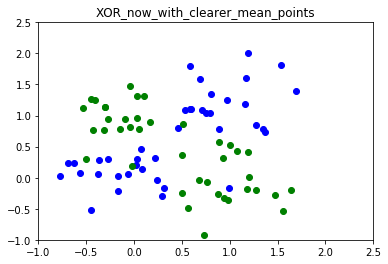

In [51]:
#Create a function that creates a dataset 

def generate_dataset(size, sigma = 0.1):
    means = np.array([[0,1],[1,0],[0,0],[1,1]])
    #used sqrt(0.1), because otherwise spread is too much
    div = size/len(means)
    data = np.zeros((size, 3))
    
    for i in range(0, len(means)):
            #First two columns location, third column type
            data[div*i:div*(i+1),0:2] = np.random.multivariate_normal(means[i, :], sigma*np.eye(2),(size/4,)) #x1, x2
            data[div*i:div*(i+1), 2] = np.floor(i/2) #y
    return data


data_trainset = generate_dataset(80)

data_testset = generate_dataset(80)

group1 = data_trainset[:,2] > 0.5
group2 = data_trainset[:,2] < 0.5

plt.scatter(data_trainset[group1, 0], data_trainset[group1, 1], c = 'b')
plt.scatter(data_trainset[group2, 0], data_trainset[group2, 1], c = 'g')
plt.xlim(-1, 2.5)
plt.ylim(-1, 2.5)
plt.title("XOR_now_with_clearer_mean_points")
plt.show()

In [52]:
#The Support-vector class uses as default the RBF kernel
#training
rbfclassif = SVC()
rbfclassif.fit(data_trainset[:, 0:2], data_trainset[:, 2]) 


train_prediction = rbfclassif.predict(data_trainset[:, 0:2])

In [53]:
#printing stuff
test_predict = rbfclassif.predict(data_testset[:, 0:2])

err_rate = np.sum(np.abs(test_predict - data_testset[:, 2]))/len(test_predict)
t_error_rate = np.sum(np.abs(train_prediction - data_trainset[:, 2]))/len(train_prediction)


print "Train_data: Percent correct on training data is "
print (1 - t_error_rate)*100
print "Rate of error on training data is "
print t_error_rate*100
print "test data"
print "Percent correct on test data is ", (1 - err_rate)*100, "\nRate of error on test data is ", err_rate*100


Train_data: Percent correct on training data is 
91.25
Rate of error on training data is 
8.75
test data
Percent correct on test data is  82.5 
Rate of error on test data is  17.5


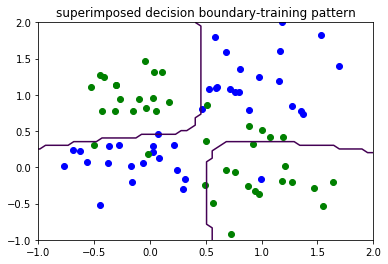

In [54]:
axis = np.linspace(-2, 2, 80)

grid = np.empty((len(axis),len(axis)))

for i in range(0,len(axis)):
    for j in range(0,len(axis)):
        #print a[i], a[j]
        grid[i,j] = rbfclassif.predict(np.array([axis[i], axis[j]]).reshape(-2,2))

#Scatterplot and decision boundary superimposed
plt.scatter(data_trainset[group1, 0], data_trainset[group1, 1], c = 'b')
plt.scatter(data_trainset[group2, 0], data_trainset[group2, 1], c = 'g')
plt.xlim([-1, 2])
plt.ylim([-1, 2])

plt.contour(axis, axis, grid, 1)
plt.title("superimposed decision boundary-training pattern")
plt.show()

In [55]:
#9-3
#a
#Range of parameters for C and gamma
C_value = np.arange(-5, 16, 2)
C_value = np.power(2., C_value)
gamma_value = np.arange(-15, 4, 2)
gamma_value = np.power(2., gamma_value)


dataCV = generate_dataset(80)


nsubset = 8

mean_training_matrix = np.zeros((len(C_value), len(gamma_value)))
crossvalidation_matrix = mean_training_matrix.copy()
#print np.shape(mean_training_matrix), len(C_value), len(gamma_value)

In [56]:
def k_fold(data, n_subsets, c, g):
    training_results = np.zeros(n_subsets)
    test_results = training_results.copy()
    
    one_slice = len(data)/n_subsets
    rest = len(data) - one_slice
    for i in range(0, n_subsets):
        #Split data as training and test
        training = np.append(data[0:one_slice*i, :], data[one_slice*(i+1):, :], axis = 0)
        test = data[one_slice*i: one_slice*(i+1), :]
        rbfclassif = SVC(C = c, kernel = 'rbf', gamma = g)
        rbfclassif.fit(training[:, 0:2], training[:, 2])
        
        
        y_pred_train = rbfclassif.predict(training[:, 0:2])
        y_pred_test = rbfclassif.predict(test[:, 0:2])
        training_results[i] = (np.sum(np.abs(y_pred_train - training[:, 2]) - 1) * -1)
        test_results[i] = (np.sum(np.abs(y_pred_test - test[:, 2]) - 1) * -1)
    return np.average(training_results)/rest, np.average(test_results)/one_slice

for i in range(0, len(C_value)):
    for j in range(0, len(gamma_value)):
        mean_tr, cv = k_fold(dataCV, nsubset, C_value[i], gamma_value[j]) #return mean training performance and crossvalidation performance
        mean_training_matrix[i, j] = mean_tr
        crossvalidation_matrix[i, j] = cv

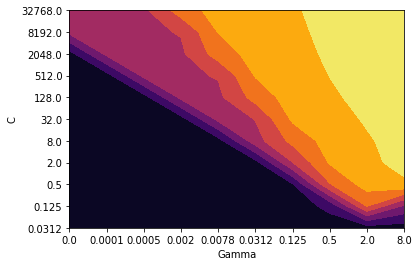

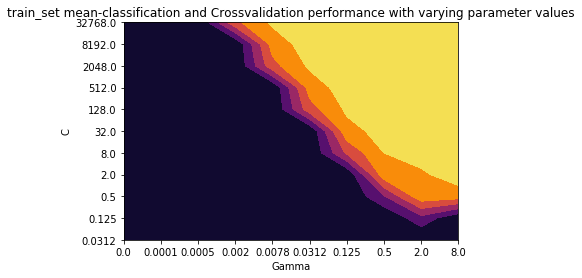

In [57]:
plt.contourf(mean_training_matrix, cmap = 'inferno')
plt.xlabel("Gamma")
plt.ylabel("C")
plt.xticks(np.arange(10), np.round(gamma_value, decimals = 4))
plt.yticks(np.arange(11), np.round(C_value, decimals = 4))


plt.figure()

#
plt.contourf(crossvalidation_matrix, cmap = 'inferno')
plt.xlabel("Gamma")
plt.ylabel("C")
plt.xticks(np.arange(10), np.round(gamma_value, decimals = 4))
plt.yticks(np.arange(11), np.round(C_value, decimals = 4))
plt.title("train_set mean-classification and Crossvalidation performance with varying parameter values")
plt.show()



The success rate is getting higher, the brighter the area on the plots is

In [58]:
#b
best = np.unravel_index(np.argmax(crossvalidation_matrix), np.shape(crossvalidation_matrix))
print "best values - Indexes : ", best
print "best values Correct rate :", crossvalidation_matrix[best[0], best[1]]

print "Best c: " ,C_value[best[0]], "Best gamma: " ,gamma_value[best[1]]

best values - Indexes :  (9, 6)
best values Correct rate : 0.8625
Best c:  8192.0 Best gamma:  0.125


In [59]:
new_clf = SVC(C = C_value[best[0]], kernel = 'rbf', gamma = gamma_value[best[1]])
new_clf.fit(dataCV[:, 0:2], dataCV[:, 2])
y_pred_final = new_clf.predict(dataCV[:, 0:2])

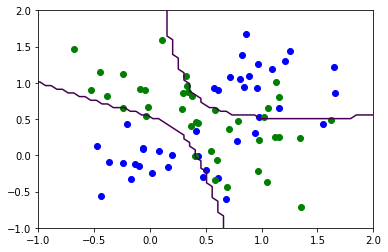

In [60]:
a = np.linspace(-2, 2, 80)

grid = np.zeros((len(a),len(a)))

group1 = dataCV[:,2] > 0.5
group2 = dataCV[:,2] < 0.5

for i in range(0,len(a)):
    for j in range(0,len(a)):
        grid[i,j] = new_clf.predict(np.array([a[i], a[j]]).reshape(-2,2))


plt.scatter(dataCV[group1, 0], dataCV[group1, 1], c = 'b')
plt.scatter(data_testset[group2, 0], data_testset[group2, 1], c = 'g')
plt.xlim([-1, 2])
plt.ylim([-1, 2])

plt.contour(a, a, grid, 1)

best_param_performance = (np.sum(np.abs(y_pred_final - dataCV[:, 2]) - 1) * -1)/ len(y_pred_final)

In [61]:
#c

print 1-err_rate, best_param_performance

#Number of support vectors
print len(rbfclassif.support_), len(new_clf.support_)



#SVM uses less support vectors when used with with optimized parameters.
# without these parameters, more support vectors are used
# Optimized SVM performs better than without opimized parameters


0.825 0.9375
53 17
